# Matthew Burrell
# Jason Lee
# Eric Laverdiere
# Max Wiedmann

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tmdb-box-office-prediction/sample_submission.csv
/kaggle/input/tmdb-box-office-prediction/test.csv
/kaggle/input/tmdb-box-office-prediction/train.csv


In [2]:
df = pd.read_csv('/kaggle/input/tmdb-box-office-prediction/train.csv')
kags = pd.read_csv('/kaggle/input/tmdb-box-office-prediction/test.csv')

In [3]:
from datetime import datetime
import math
import regex
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, VotingRegressor, ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [4]:
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
          
def check_frame(frame, numericals=[], drop = 0, fill=False):

    '''Check/clean a dataframe by identifying missing values and checking numeric column data types. Feature names are converted to snake case
    Numericals - List: Feature names which should contain only numerical values. Prints column name and and any inconsistencies found. Default = False, does not check types
    Drop - Float: Null rows in a feature are dropped if the percentage of null rows is less than threshold. Default = 0, no rows are removed from the data set. Set to 1 if you want all null rows dropped
    Fill - Any: Replace all null values with the passed value. Default = False, leave null values as is'''

    frame.columns = [col.lower().replace(' ','_') for col in frame.columns]
    numericals = [x.lower() for x in numericals]

    if frame.isna().sum().sum() == 0:
        print('No null values in data set')        
    elif fill:
        frame.fillna(fill, inplace=True)
        print(f'All null values converted to {fill}')
    else:
        for col in frame.columns:
            nulls = frame[[col]].isna().sum()[0]
            null_warning = f'{col}: {nulls} null'
            if nulls > 0:
                if (nulls/len(frame)) < drop:
                    frame.dropna(subset=[col], inplace=True)
                    null_warning += ' rows dropped'
                else:
                    null_warning += ' values'
                print(null_warning)

    if len(numericals) > 0:
        print(f'Checking for numerical type mismatches in features: {numericals}')
        no_mismatch = True
        non_numeric = [x for x in numericals if not np.issubdtype(frame[x].dtype, np.number)]
        for non in non_numeric:
            nonval = [y for y in frame[non] if not np.issubdtype(type(y), np.number)]
            print(f'Feature [{non}]: {len(nonval)} non-numeric values')
            no_mismatch = False          

        if no_mismatch:
            print(f'No type mismatches found')

def impute_frame(frame, reference, threshold = 1, modes = [], medians = [], zeroes=[]):

    '''Generalized function for imputing values in a dataframe
    Reference - Dataframe: Training data to take the modes and medians for feature values from
    Threshold - Float: Only impute the column if the percentage of missing values is lower than the threshold. Default = 1: Impute all values
    Modes - List: Feature names that are either categorical or ordinal. Replace null values with the mode of the feature
    Medians - List: Feature names that are either continuous or discrete numerical values. Replace null values with the median of the feature
    Zeroes - List: Feature names that will have their null values replaced by zeroes'''

    for arg_lists in [modes, medians, zeroes]:
        arg_lists = [x.lower().replace(' ','_') for x in arg_lists]

    for mode in modes:
        nulls = frame[mode].isna().sum()
        if nulls/len(frame) < threshold and nulls != 0:                   
            mode_val = statistics.mode(reference[mode].copy().dropna())
            frame.fillna({mode:mode_val}, inplace=True)
            print(f'Feature [{mode}]: {nulls} null values converted to {mode_val}')

    for median in medians:
        nulls = frame[median].isna().sum()
        if nulls/len(frame) < threshold and nulls != 0:
            median_val = statistics.median(reference[median].copy().dropna())
            frame.fillna({median:median_val}, inplace=True)
            print(f'Feature [{median}]: {nulls} null values converted to {median_val}')

    for zero in zeroes:
        nulls = frame[zero].isna().sum()
        if nulls/len(frame) < threshold and nulls != 0:
            frame.fillna({zero:0}, inplace=True)
            print(f'Feature [{zero}]: {nulls} null values converted to 0')

def scale_frame(frame, scalable, scaler):

    '''Normalizes the values of the passed features in the data set
    Scalable - List: Feature names of the data set to be scaled
    Reference - Fitted StandardScaler Instance: Already fitted (to train data) scaler'''

    scaled = scaler.transform(frame[scalable])
    for _ in enumerate(scalable):
        frame.loc[:, _[1]] = scaled.transpose()[_[0]]


def check_range(frame, numericals, correct=False):

    '''Checks the values of numerical features of a dataframe to see if they're within a certain range
    Numericals - Dictionary: Keys are feature names, values are list of minimum/maximum e.g. "Survey Result": [0,5]. A string of 'none' for max/min does not check for that boundary
    Correct: Default - False, leave values in place, but print warning. If set to True, out of bounds values are changed to the minimum or maximum'''

    print(f'Checking for out of range values in features: {list(numericals.keys())}')
    no_errors = True

    for key in numericals:
        key = key.lower().replace(' ','_')
        actual_min, actual_max = frame.describe()[key][3], frame.describe()[key][-1]

        minimum, maximum = numericals[key][0], numericals[key][1]

        if minimum != 'none':
            if actual_min < minimum:
                min_message = ' out of range'
                if correct:
                    frame[key] = frame[key].map(lambda _: minimum if _ < minimum else _)
                    min_message = 's corrected'

                print(f'Feature [{key}] minimum value' + min_message)
                no_errors = False

        if maximum != 'none':
            if actual_max > maximum:
                max_message = ' out of range'
                if correct:
                    frame[key] = frame[key].map(lambda _: maximum if _ < maximum else _)
                    max_message = 's corrected'

                print(f'Feature [{key}] maximum value' + min_message)
                no_errors = False

    if no_errors:
        print(f'No out of range values in selected features')


def match_columns(frame_one, frame_two):

    '''Compares the column headers of two dataframes and creates any missing columns in both frames from the union of the two
    Checks to see if columns are no longer aligned, due to missing values in categorical/ordinal variables. Code taken from stack overflow
    https://stackoverflow.com/questions/28444561/get-only-unique-elements-from-two-lists-python/45098345
    Sort and order columns to match between test and training dataframes'''

    one = frame_one.columns
    two = frame_two.columns

    unique = list(set(one).symmetric_difference(set(two)))
    for uniqcol in unique:
        if uniqcol in one:
            frame_two[uniqcol] = 0
        else:
            frame_one[uniqcol] = 0

    sorted_columns = list(frame_one.columns)
    sorted_columns.sort()

    return frame_one[sorted_columns], frame_two[sorted_columns]

# Returns a reversed slice of a range of indices from a list

def rev_range(x, low=0, high=10):
    return x[low:high][:(low-high)-1:-1]

def collapse_ordinal(frame, key, correct_range, bins):

    '''Collapses an ordinal variable into a smaller number of values and rewrites the original dataframe column with the adjusted numbers. Returned values start with 1
    Key - String: Feature name of the dataframe to collapse
    Correct Range - 2-element List: Contains the actual values for the [minimum, maximum] of the variable
    Bins - Int: Number of values to collapse the ordinal to'''

    def correct_value(bin_ranges, value):
        numbers = np.arange(1, len(bin_ranges))
        for x in range(len(bin_ranges)-1):
            if bin_ranges[x] <= value < bin_ranges[x+1]:
                return numbers[x]
        return numbers[-1]

    bin_list = []
    for x in range(bins):
        bin_list.append(correct_range[0] + x*((correct_range[1] - correct_range[0])/bins))
    bin_list.append(correct_range[1])

    frame[key] = frame[key].map(lambda _: correct_value(bin_list, _))

def create_scatter(x, y, title = None, xlabel = None, ylabel = None, size = (6,4), fitline = []):

    '''Creates a scatter plot using matplotlib and the passed arguments
    x, y - List: x and y coordinate data. Lists must be of equal length
    Title, xlabel, ylabel - Str: Text for the figure title and axes
    Size - Tuple: Two element tuple defining the width and height of the figure
    Fitline - List: Two element list to draw a custom fit line on the chart. List should include two nested lists of two elements start [x,y] and finish [x,y] coordinates for the line'''

    mpl.style.use('ggplot')

    plt.figure(figsize=size)
    plt.scatter(x, y)
    if len(fitline) != 0:
        plt.plot(fitline[0], fitline[1], color='blue', linewidth=2)

    xmax, xmin = plt.xticks()[0][1], plt.xticks()[0][-2]
    ymax, ymin = plt.yticks()[0][1], plt.yticks()[0][-2]
    plt.hlines(0, xmin, xmax, color='k', linewidth=2)
    plt.vlines(0, ymin, ymax, color='k', linewidth=2)
    plt.grid(False)

    plt.xlabel(xlabel, fontsize=10)
    plt.xticks(fontsize=8)
    plt.ylabel(ylabel, fontsize=10)
    plt.yticks(fontsize=8)
    plt.title(title, fontsize=14)
    plt.show()        

def create_hist(x, title = None, xlabel = None, ylabel = None, size = (6,4), bins = 10):

    '''Create a histogram using matplotlib and the passed arguments
    x - List: Series data to be plotted
    Title, xlabel, ylabel - Str: Text for the figure title and axes
    Size - Tuple: Two element tuple defining the width and height of the figure
    Bins - Int: Number of bins to assign values to. Default = 10'''

    mpl.style.use('ggplot')

    plt.figure(figsize=size)
    plt.hist(x, bins=bins)

    plt.xlabel(xlabel, fontsize=10)
    plt.xticks(fontsize=8)
    plt.ylabel(ylabel, fontsize=10)
    plt.yticks(fontsize=8)
    plt.title(title, fontsize=14)
    plt.show()
    return plt

def create_bar(x, title = None, xlabel = None, ylabel = None, ticks = '', size = (6,4), axis = 'v'):

    '''Create a bar chart using matplotlib and the passed arguments
    x - List: Series data to be plotted
    Title, xlabel, ylabel - Str: Text for the figure title and axes. Axes are reversed for horionztal charts
    Size - Tuple: Two element tuple defining the width and height of the figure
    Axis - Str: h for horizontal bar charts, y for vertical. Default = vertical
    Code for adding bar labels taken from stack overflow
    https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh'''

    mpl.style.use('ggplot')

    plt.figure(figsize=size)
    if axis == 'h':
        plt.barh(np.arange(1, len(x)+1), x, tick_label = ticks)
        plt.xlabel(ylabel, fontsize=10)
        plt.ylabel(xlabel, fontsize=10)

        for i, v in enumerate(x):
            plt.text(v + 0.02, i + .9, str(v), color='blue', fontweight='bold')
    else:
        plt.bar(np.arange(1, len(x)+1), x, tick_label = ticks)
        plt.xlabel(xlabel, fontsize=10)
        plt.ylabel(ylabel, fontsize=10)

    plt.title(title, fontsize=14)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    plt.show()

def create_box(x, title = None, label = None, size = (6,4)):

    mpl.style.use('ggplot')

    plt.figure(figsize=size)
    plt.boxplot(x, vert=False, widths=0.6)

    plt.yticks([])

    plt.xlabel(label, fontsize=10)
    plt.xticks(fontsize=8)
    plt.title(title, fontsize=14)
    plt.show()
    
def subplot(type_list, x_list, title_list, xlab_list, ylab_list, y_list = None, fig_title='', h_size='default', bar_numbers=False):
    
    mpl.style.use('ggplot')
    sup_y = 1
    if len(type_list) == 2:
        columns = 2
    else:
        columns = 3
    
    nrows = int(np.ceil(len(x_list)/3))
    if h_size == 'default':
        h_size = 18
    fig, ax = plt.subplots(nrows=nrows, ncols=columns, figsize=(h_size,(nrows*4)+1))
    ax = ax.ravel()
    for i, column in enumerate(x_list):
        ax[i].set_title(title_list[i])
        ax[i].set_xlabel(xlab_list[i])
        ax[i].set_ylabel(ylab_list[i])
        
        type_dict = {'hist':ax[i].hist,
                 'bar':ax[i].bar,
                 'box':ax[i].boxplot,
                 'scatter':ax[i].scatter,
                 'barh':ax[i].barh}
        if type_list[i] in ['hist', 'box']:
            type_dict[type_list[i]](x_list[i])
            sup_y = 1
        else:
            type_dict[type_list[i]](x_list[i], y_list[i])
            if type_list[i] == 'bar':
                ax[i].set_xticks(x_list[i])
                ax[i].set_xticklabels(xlab_list[i])
                ax[i].set_xlabel('')
                if bar_numbers:
                    for z, v, in enumerate(y_list[i]):
                        ax[i].text(z-(len(str(v))*(.6/15)), v+0.15, str(v), color='blue', fontweight='bold')

            if type_list[i] == 'barh':
                ax[i].set_yticks(x_list[i])
                ax[i].set_yticklabels(ylab_list[i])
                ax[i].set_ylabel('')
                if bar_numbers:
                    for z, v in enumerate(y_list[i]):
                        ax[i].text(v + 0.02, z-(0.015*len(ylab_list[i])), str(v), color='blue', fontweight='bold')
                        sup_y = 1



                                        
    if len(type_list)%3 > 0 and len(type_list) != 2:
        for x in range(3 - len(type_list)%3):
            fig.delaxes(ax[-(x+1)])
    plt.suptitle(fig_title, fontsize=18, y = sup_y)
    if nrows > 1:
        fig.subplots_adjust(hspace=0.4)
                                        
    plt.show()
    
def multi_histo(dists, labels, bins=10, title='', xlabel = '', ylabel = '', show_kde=False, norm=False):
    for x in range(len(dists)):
        counts = sns.distplot(dists[x], kde=show_kde, norm_hist=norm, label=labels[x])
    counts.set_title(title)
    counts.set_xlabel(xlabel)
    counts.set_ylabel(ylabel)
    counts.legend()
    
def top_words(frame, ref, num):
    
    '''Returns a dictionary of the most frequent words from a CountVectorizer dataframe
    Frame - DataFrame: Dataframe constructed from a CountVectorizer.transform
    Ref - CountVectorizer: The CountVectorizer which generated the words of interest. Should be the same as the one which constructed the dataframe in the arguments
    Num - Int: The number of top words desired to be returned'''

    top_words = {}
    for i in ref.get_feature_names():
        top_words[i] = frame[i].sum() 

    most_freq = pd.DataFrame(sorted(top_words.items(), key = lambda x: x[1], reverse = True))
    most_freq.columns = ['word','count']
    
    if num == 0:
        return top_words
    else:
        return {most_freq['word'][x]: most_freq['count'][x] for x in range(num)}

# Data Cleaning & EDA

In [5]:
check_frame(df)

belongs_to_collection: 2396 null values
genres: 7 null values
homepage: 2054 null values
overview: 8 null values
poster_path: 1 null values
production_companies: 156 null values
production_countries: 55 null values
runtime: 2 null values
spoken_languages: 20 null values
tagline: 597 null values
keywords: 276 null values
cast: 13 null values
crew: 16 null values


In [6]:
# Convert release_date into datetime object, pull month and year and assign to unique column

df['month'] = [datetime.strptime(x, '%m/%d/%y').month for x in df['release_date']]
df['year'] = [datetime.strptime(x, '%m/%d/%y').year for x in df['release_date']]

In [7]:
# Fix for years above 2020
df['year'] = np.where(df['year'] > 2020, df['year']-100, df['year'])

In [8]:
# Drop 4 'rumored' status rows (minimal impact on 3000 row dataframe)

df.drop(df[df['status']=='Rumored'].index, inplace=True)

In [9]:
df

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,spoken_languages,status,tagline,title,keywords,cast,crew,revenue,month,year
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,2,2015
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,8,2004
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,10,2014
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,3,2012
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,2,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0109403,en,Chasers,Military men Rock Reilly and Eddie Devane are ...,9.853270,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was supposed to be a routine prisoner trans...,Chasers,"[{'id': 378, 'name': 'prison'}, {'id': 572, 'n...","[{'cast_id': 2, 'character': 'Rock Reilly', 'c...","[{'credit_id': '52fe4494c3a368484e02ac7d', 'de...",1596687,4,1994
2996,2997,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,tt2364975,sv,Vi är bäst!,Three girls in 1980s Stockholm decide to form ...,3.727996,...,"[{'iso_639_1': 'sv', 'name': 'svenska'}]",Released,NaN,We Are the Best!,"[{'id': 1192, 'name': 'sweden'}, {'id': 4470, ...","[{'cast_id': 5, 'character': 'Bobo', 'credit_i...","[{'credit_id': '5716b72ac3a3686678012c84', 'de...",180590,3,2013
2997,2998,NaN,65000000,"[{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...",NaN,tt0116908,en,The Long Kiss Goodnight,"Samantha Caine, suburban homemaker, is the ide...",14.482345,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,What's forgotten is not always gone.,The Long Kiss Goodnight,"[{'id': 441, 'name': 'assassination'}, {'id': ...","[{'cast_id': 10, 'character': 'Samantha Caine ...","[{'credit_id': '52fe443a9251416c7502d579', 'de...",89456761,10,1996
2998,2999,NaN,42000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",http://www.alongcamepolly.com/,tt0343135,en,Along Came Polly,Reuben Feff

In [10]:
# Create dataframe that only has our features of interest

df = df[['belongs_to_collection','budget','genres','popularity','month','year', 'revenue']]

In [11]:
# Drop rows (total 20) that have null values for either cast or genres (other features do not have null values)

df.dropna(subset=['genres'], inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
# Pull genres in the genres column using regex and assigned new value as list of genre names

df['genres'] = [regex.findall("'name': '(\w*)'", x) for x in df['genres']]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
# Lower case all genre names

df['genres'] = [[y.lower() for y in x] for x in df['genres']]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
# Create list of unique genres

all_genres = []
for x in df['genres']:
    all_genres += x
all_genres = set(all_genres)
all_genres = [x.lower() for x in all_genres]

In [15]:
# Create a column for each genre and assign 0's by default

for x in all_genres:
    df[x] = 0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [16]:
# For each movie, assign a 1 to each genre column that is found in that movie's genre list

for x in df.index:
    for y in df.loc[x, 'genres']:
        df.loc[x, y] = 1

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [17]:
# Remove genre column after it has been encoded, as well as the fantasy column (drop first)

df.drop(['genres', 'fantasy'], axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [18]:
df.reset_index(inplace=True)

In [19]:
# For each movie, assigns a 1 if it is a sequel and a zero if not. 

df['belongs_to_collection'] = df['belongs_to_collection'].map(lambda x : 0 if x is np.nan else 1 )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
df.isnull().sum()

index                    0
belongs_to_collection    0
budget                   0
popularity               0
month                    0
year                     0
revenue                  0
drama                    0
thriller                 0
adventure                0
history                  0
music                    0
crime                    0
mystery                  0
foreign                  0
horror                   0
animation                0
comedy                   0
documentary              0
family                   0
romance                  0
war                      0
western                  0
action                   0
dtype: int64

In [21]:
def get_actors_from_elem(cast_elem):
    '''
    Returns all actors from a single entry in `cast` column.
    Should really be named get_actors_from_movie...
    '''
    
    try:
        return [i['name'] for i in ast.literal_eval(cast_elem)]
    except:
        return None
    

def get_actors_by_movie(cast_col):
    '''
    Returns a column where the values are a list of actors.
    '''
    return [get_actors_from_elem(movie) for movie in cast_col]



# Find the top n (20 for now) actors 

def get_actors_list(actors_by_movie):
    
    actors_list = [] # list of all actors. Names are repeated for each movie appearance.

    for movie in actors_by_movie: # populate actors_list
        try: 
            for actor in movie:
                actors_list.append(actor)
        except: # if there's a null
            pass
    return actors_list


# https://www.digitalocean.com/community/tutorials/how-to-graph-word-frequency-using-matplotlib-with-python-3

def get_actor_frq(actor_list):
    actor_frq = {} # key is actor name, value is number of movie appearances

    for actor in actor_list:

        if (actor_frq.__contains__(actor)):
            actor_frq[actor] = int(actor_frq.get(actor)) + 1
        else:
            actor_frq[actor] = 1
            
    return actor_frq
        
def get_top_actors(actor_frq, threshold = 20): # return a list of all actors who have been in atleast `threshold` number of movies
    top = []
    for actor in actor_frq.keys():
        if actor_frq[actor] >= 20:
            top.append(actor)
    return top
    


def one_hot_actors_from_list(actors_by_movie,top_actors): # actors_by_movie is what get_actors_to_list returns
    
    df = pd.DataFrame(0, index=np.arange(len(actors_by_movie)), columns=top_actors)
    
    for i in range(len(actors_by_movie)):
        for j,actor in enumerate(df.columns):
            try:
                if actor in actors_by_movie[i]:
                    df.iloc[i,j] = 1
            except:
                pass
    return df

In [22]:
# USE THIS FUNCTION

def one_hot_actors(cast_series, threshold = 20):
    
    '''
    Pass this function the case series (df['case']) and a movies acted in threshold, `threshold`
    Returns a one hot encoded dataframe with top actors.
    '''
    
    actors_by_movie = get_actors_by_movie(cast_series)

    actors_list = get_actors_list(actors_by_movie)
    
    actor_frq = get_actor_frq(actors_list)
    
    top_actors = get_top_actors(actor_frq, threshold)
    
    return one_hot_actors_from_list(actors_by_movie, top_actors)

In [23]:
#actors_ohe = one_hot_actors(df['cast'],20)

In [24]:
#actors_ohe.shape

In [25]:
#actors_ohe.isnull().sum()

In [26]:
df

,index,belongs_to_collection,budget,popularity,month,year,revenue,drama,thriller,adventure,...,foreign,horror,animation,comedy,documentary,family,romance,war,western,action
0,0,1,14000000,6.575393,2,2015,12314651,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,1,40000000,8.248895,8,2004,95149435,1,0,0,...,0,0,0,1,0,1,1,0,0,0
2,2,0,3300000,64.299990,10,2014,13092000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,1200000,3.174936,3,2012,16000000,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,1.148070,2,2009,3923970,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2984,2995,0,0,9.853270,4,1994,1596687,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2985,2996,0,0,3.727996,3,2013,180590,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2986,2997,0,65000000,14.482345,10,1996,89456761,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2987,2998,0,42000000,15.725542,1,2004,171963386,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [27]:
#df = pd.concat([df, actors_ohe], axis = 1).drop(columns='cast')

In [28]:
df.isnull().sum()

index                    0
belongs_to_collection    0
budget                   0
popularity               0
month                    0
year                     0
revenue                  0
drama                    0
thriller                 0
adventure                0
history                  0
music                    0
crime                    0
mystery                  0
foreign                  0
horror                   0
animation                0
comedy                   0
documentary              0
family                   0
romance                  0
war                      0
western                  0
action                   0
dtype: int64

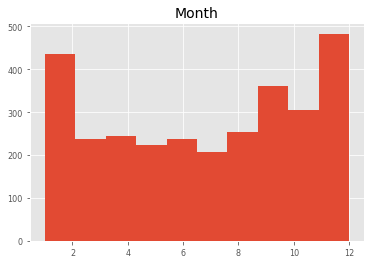

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [29]:
create_hist(df['month'], title='Month')

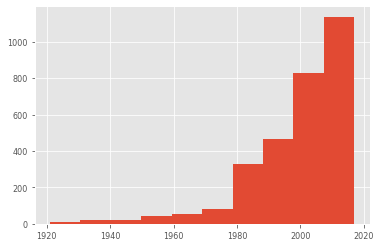

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [30]:
create_hist(df['year'])

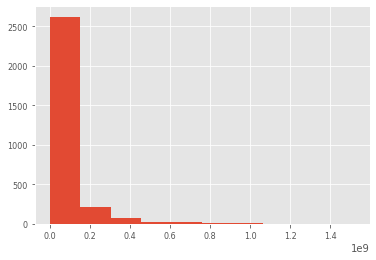

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [31]:
create_hist(df['revenue'])

In [32]:
df = pd.concat([df, pd.get_dummies(df['month'], drop_first=True)], axis=1).drop(columns='month')

In [33]:
X = df.drop(columns='revenue')

In [34]:
X2 = df.drop(columns='revenue')

In [35]:
X2.head()

,index,belongs_to_collection,budget,popularity,year,drama,thriller,adventure,history,music,...,3,4,5,6,7,8,9,10,11,12
0,0,1,14000000,6.575393,2015,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,40000000,8.248895,2004,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2,0,3300000,64.299990,2014,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,3,0,1200000,3.174936,2012,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,4,0,0,1.148070,2009,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
X.head()

,index,belongs_to_collection,budget,popularity,year,drama,thriller,adventure,history,music,...,3,4,5,6,7,8,9,10,11,12
0,0,1,14000000,6.575393,2015,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,40000000,8.248895,2004,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2,0,3300000,64.299990,2014,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,3,0,1200000,3.174936,2012,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,4,0,0,1.148070,2009,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
def scale(series):
    mean = series.mean()
    std = series.std()
    return (series - mean) / std

In [38]:
X['budget'] = scale(X['budget'])

In [39]:
X['year'] = scale(X['year'])

In [40]:
X

,index,belongs_to_collection,budget,popularity,year,drama,thriller,adventure,history,music,...,3,4,5,6,7,8,9,10,11,12
0,0,1,-0.232316,6.575393,0.989999,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0.469056,8.248895,0.277819,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2,0,-0.520958,64.299990,0.925256,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,3,0,-0.577607,3.174936,0.795768,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,4,0,-0.609978,1.148070,0.601537,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2984,2995,0,-0.609978,9.853270,-0.369617,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2985,2996,0,-0.609978,3.727996,0.860512,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2986,2997,0,1.143452,14.482345,-0.240130,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2987,2998,0,0.523007,15.725542,0.277819,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


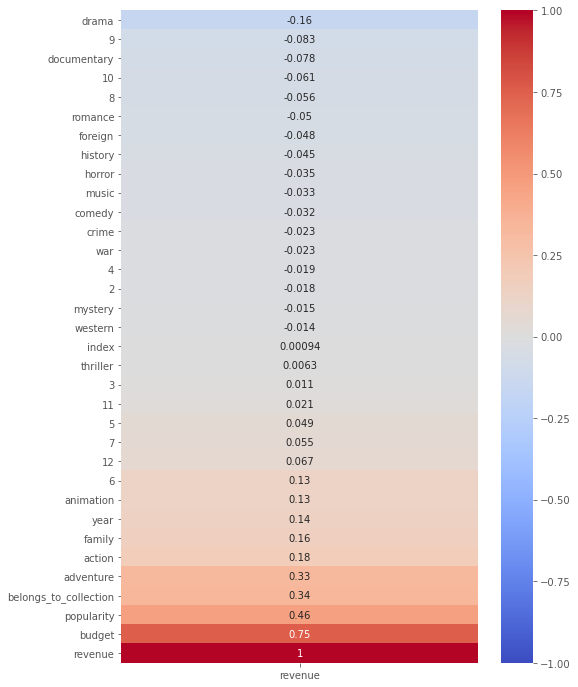

In [41]:
plt.figure(figsize=(8, 12))
sns.heatmap(df.corr()[['revenue']].sort_values('revenue'),
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1)

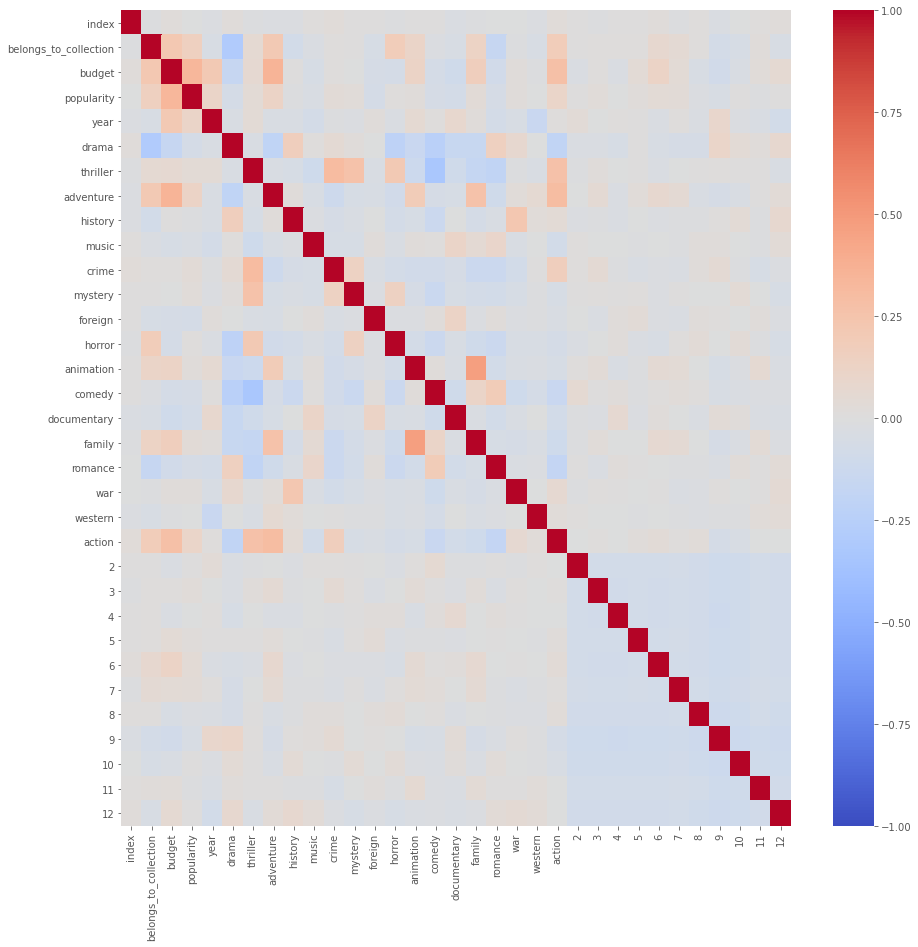

In [42]:
plt.figure(figsize=(15,15))
sns.heatmap(X.corr(), cmap='coolwarm', vmin=-1, vmax=1)

# Modeling

In [43]:
y = df['revenue']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X2,y, random_state=42)

In [45]:
vote = VotingRegressor([   
    ('grad_boost', GradientBoostingRegressor()),
    ('tree', DecisionTreeRegressor()),
    ('rf', RandomForestRegressor()),
    ('lr', LinearRegression()),
    ('et', ExtraTreesRegressor())
])
vote.fit(X_train,y_train)

VotingRegressor(estimators=[('grad_boost', GradientBoostingRegressor()),
                            ('tree', DecisionTreeRegressor()),
                            ('rf', RandomForestRegressor()),
                            ('lr', LinearRegression()),
                            ('et', ExtraTreesRegressor())])

In [46]:
vote.score(X_train,y_train)

0.9529402874489195

In [47]:
vote.score(X_test,y_test)

0.6566113533382756

In [48]:
lr = LinearRegression()

In [49]:
lr.fit(X_train, y_train)

LinearRegression()

In [50]:
lr.score(X_train, y_train)

0.6687954291433162

In [51]:
lr.score(X_test, y_test)

0.5961832924835433

In [52]:
# get predictions from our X data

y_hat = lr.predict(X_train)

In [53]:
# calculate residuals

res = y_train - y_hat


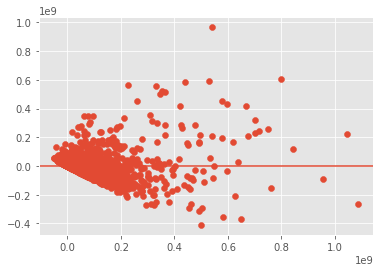

In [54]:
# L and E assumptions -
plt.scatter(y_hat, res)
plt.axhline(0, )

# Submission

In [55]:
df_test = pd.read_csv('/kaggle/input/tmdb-box-office-prediction/test.csv')

In [56]:
df_test['genres'] = df_test['genres'].fillna('')

In [57]:
df_test['release_date'] = df_test['release_date'].fillna('1/1/20')

In [58]:
df_test['cast'] = df_test['cast'].fillna('')

In [59]:
df_test.isnull().sum()

id                          0
belongs_to_collection    3521
budget                      0
genres                      0
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                0
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                        0
crew                       22
dtype: int64

In [60]:
# Convert release_date into datetime object, pull month and year and assign to unique column

df_test['month'] = [datetime.strptime(x, '%m/%d/%y').month for x in df_test['release_date']]
df_test['year'] = [datetime.strptime(x, '%m/%d/%y').year for x in df_test['release_date']]

In [61]:
df_test = df_test[['id','belongs_to_collection','budget','genres','popularity','month','year']]

In [62]:
# Pull genres in the genres column using regex and assigned new value as list of genre names

df_test['genres'] = [regex.findall("'name': '(\w*)'", x) for x in df_test['genres']]

In [63]:
# Lower case all genre names

df_test['genres'] = [[y.lower() for y in x] for x in df_test['genres']]

In [64]:
# Create list of unique genres

all_genres = []
for x in df_test['genres']:
    all_genres += x
all_genres = set(all_genres)
all_genres = [x.lower() for x in all_genres]

In [65]:
# Create a column for each genre and assign 0's by default

for x in all_genres:
    df_test[x] = 0

In [66]:
# For each movie, assign a 1 to each genre column that is found in that movie's genre list

for x in df_test.index:
    for y in df_test.loc[x, 'genres']:
        df_test.loc[x, y] = 1

In [67]:
# Remove genre column after it has been encoded, as well as the fantasy column (drop first)

df_test.drop(['genres', 'fantasy'], axis=1, inplace=True)

In [68]:
df_test.reset_index(inplace=True)

In [69]:
# For each movie, assigns a 1 if it is a sequel and a zero if not. 

df_test['belongs_to_collection'] = df_test['belongs_to_collection'].map(lambda x : 0 if x is np.nan else 1 )

In [70]:
#actors_ohe_test = one_hot_actors(df_test['cast'],20)

In [71]:
#actors_ohe_test.shape

In [72]:
#df_test = pd.concat([df_test, actors_ohe_test], axis = 1).drop(columns='cast')

In [73]:
df_test = pd.concat([df_test, pd.get_dummies(df_test['month'], drop_first=True)], axis=1).drop(columns='month')

In [74]:
df_test.shape

(4398, 34)

In [75]:
sub = pd.DataFrame()

In [76]:
X_val = df_test.drop(columns='id')

In [77]:
sub['revenue'] = vote.predict(X_val)

In [78]:
sub['id'] = df_test['id']

In [79]:
sub['revenue'] = sub['revenue'].map(lambda x: 0 if x < 0 else x)

In [80]:
sub

,revenue,id
0,3.942953e+07,3001
1,2.552306e+05,3002
2,1.879037e+07,3003
3,2.549429e+07,3004
4,1.290988e+07,3005
...,...,...
4393,6.476640e+07,7394
4394,4.799098e+07,7395
4395,9.957590e+07,7396
4396,1.931397e+07,7397


In [81]:
sub.to_csv('working.csv', index = False)